# Imports

In [1]:
import os
import warnings
import pickle
from numba.core.errors import NumbaDeprecationWarning
import pandas as pd
from anndata import read_h5ad
import scanpy as sc

import palantir

import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
matplotlib.rcParams["figure.dpi"] = 150
matplotlib.rcParams["figure.figsize"] = [6, 6]
matplotlib.rcParams["image.cmap"] = "Spectral_r"
matplotlib.rcParams["axes.spines.bottom"] = "off"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "off"
matplotlib.rcParams["axes.spines.right"] = "off"
matplotlib.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams["font.family"] = "sans-serif"
warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)

In [3]:
rna_annData_file = "/fh/fast/setty_m/user/msetty/projects/sc-density/data/bone-marrow-tcelldep/cleanup/bm_rna_ad.h5ad"
plot_basis = "umap"
dm_ncomp = 20
early_celltype = "HSC"
terminal_celltypes = ["Ery", "Mono", "Mega", "NaiveB", "pDC", "cDC"]

out_path = "../data/"

# Load data

In [4]:
ad = read_h5ad(rna_annData_file)
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'distance_to_closest', 'log_density', 'celltype_combined', 'palantir_pseudotime', 'clipped_log_density', 'log_density_rank'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'celltype_combined_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_FDL_orig', 'X_pca', 'X_umap', 'X_umap_orig', 'palantir_branch_probs'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'connectivities', 'distances', 'knn'

In [5]:
if f"X_{plot_basis}" in ad.obsm:
    plbasis = plot_basis
else:
    warnings.warn(f"Plot basis {plot_basis} not found!")
    plbasis = "umap"
embedding_basis = f"X_{plbasis}"

ad.obs["celltype"] = ad.obs["celltype_combined"]
ad.uns["celltype_colors"] = ad.uns["celltype_combined_colors"]
ad.obsm["palantir_fate_probabilities"] = ad.obsm["palantir_branch_probs"]

ad.obsm['palantir_branch_probs']['NaiveB'] = ad.obsm['palantir_branch_probs']['preproB'] + ad.obsm['palantir_branch_probs']['NaiveB']

In [6]:
del ad.obs["log_density"]
del ad.obs["log_density_rank"]
del ad.obs["clipped_log_density"]
del ad.obs["distance_to_closest"]
del ad.obs["celltype_combined"]
del ad.obsm["X_FDL_orig"]
del ad.obsm["X_umap_orig"]
del ad.uns["celltype_combined_colors"]
del ad.obsm['palantir_branch_probs']['preproB']

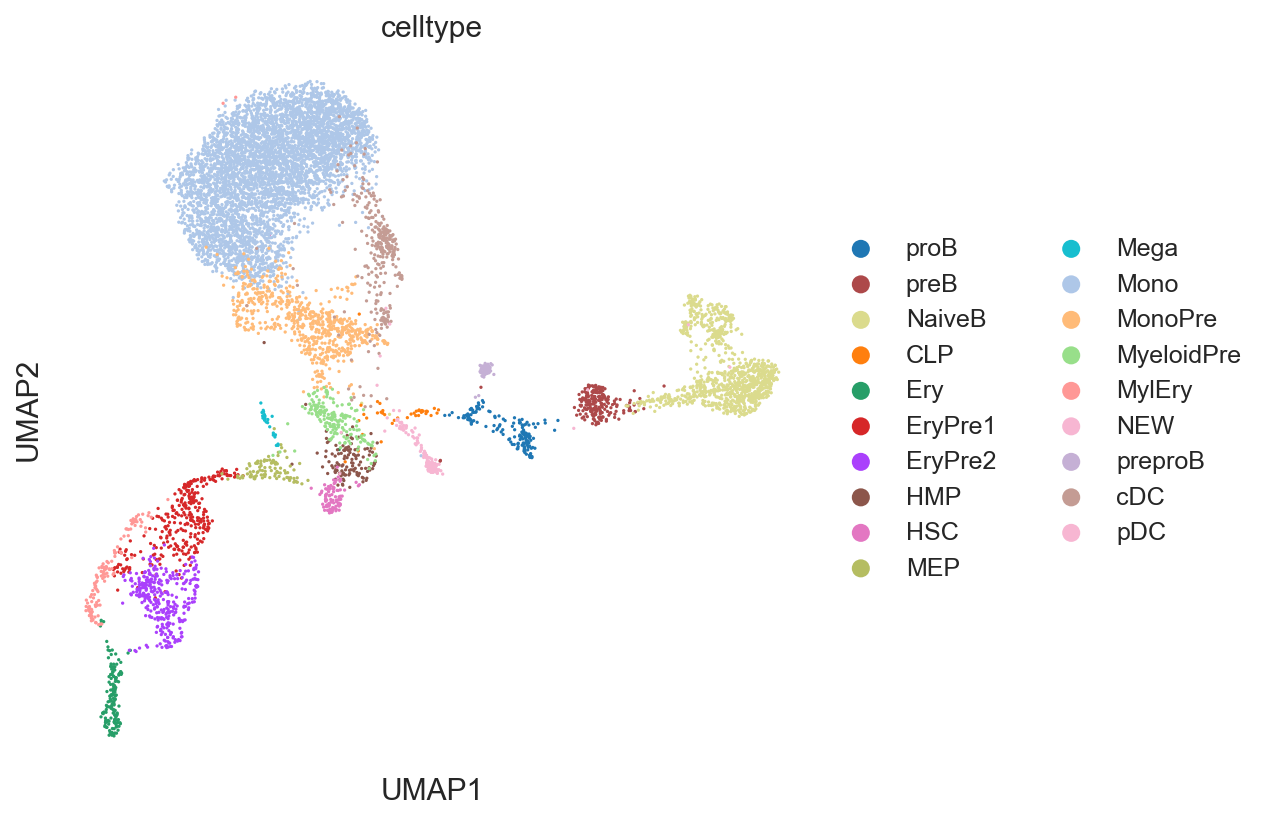

In [7]:
sc.pl.scatter(
    ad,
    basis=plbasis,
    color=[
        "celltype",
    ],
    legend_fontsize=12,
    size=10,
)

# Cleanup

There are 4 cells annotated as 'NEW'.


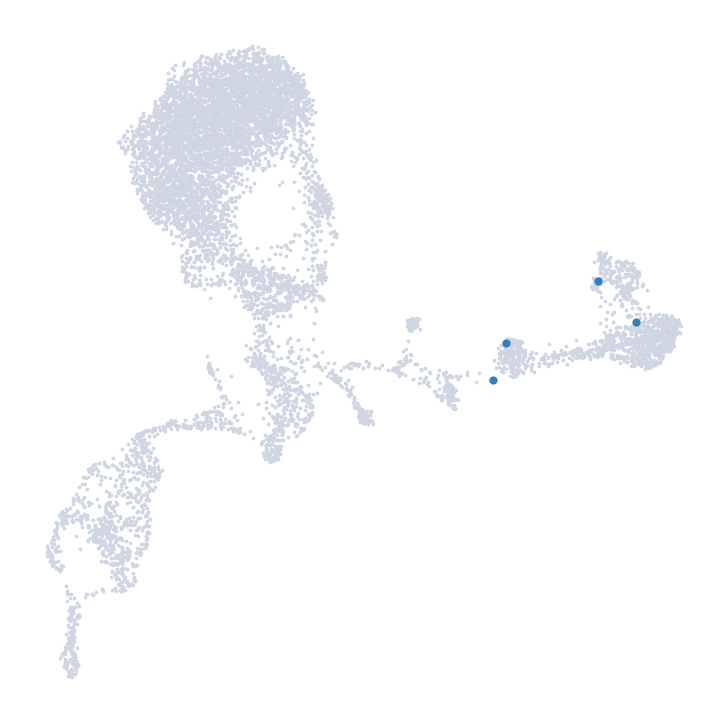

In [8]:
ad.obs["selection"] = ad.obs["celltype"] == "NEW"
old_colors = dict(zip(ad.obs["celltype"].cat.categories, ad.uns["celltype_colors"]))
n_sel = ad.obs["selection"].sum()
print(f"There are {n_sel} cells annotated as 'NEW'.")
palantir.plot.highlight_cells_on_umap(ad, "selection")
plt.show()
cells = ad.obs_names[ad.obs["selection"]]

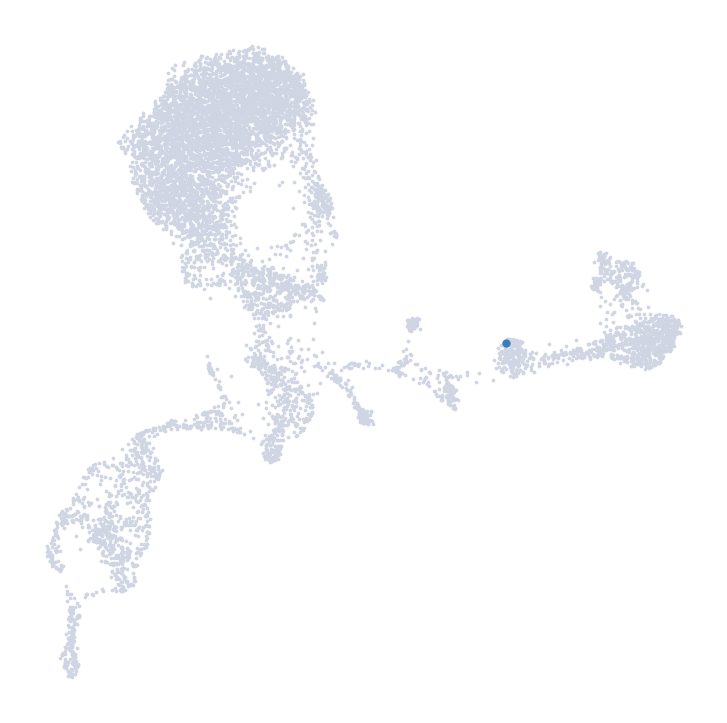

In [9]:
selection = [cells[2]]
palantir.plot.highlight_cells_on_umap(ad, selection)
ad.obs.loc[selection, "celltype"] = "preB"
plt.show()

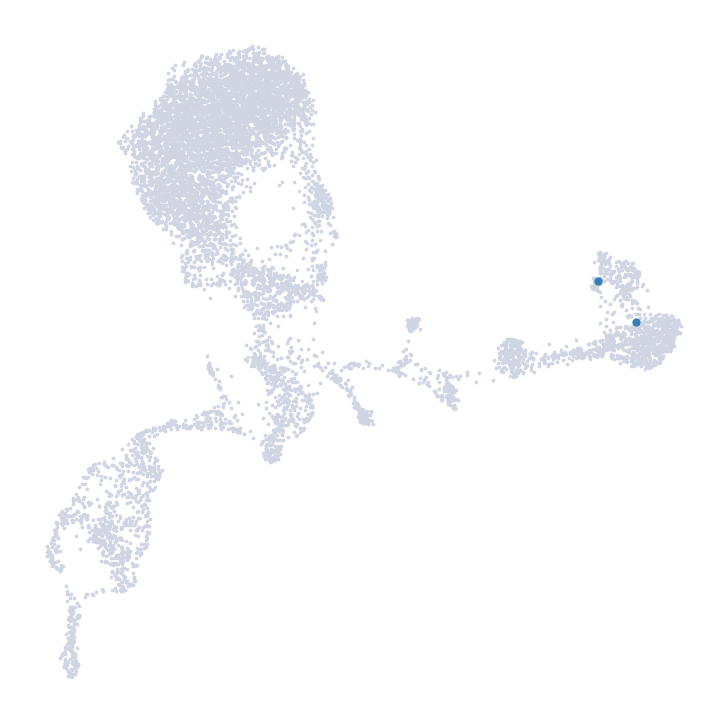

In [10]:
selection = cells[:-2]
palantir.plot.highlight_cells_on_umap(ad, selection)
ad.obs.loc[selection, "celltype"] = "NaiveB"
plt.show()

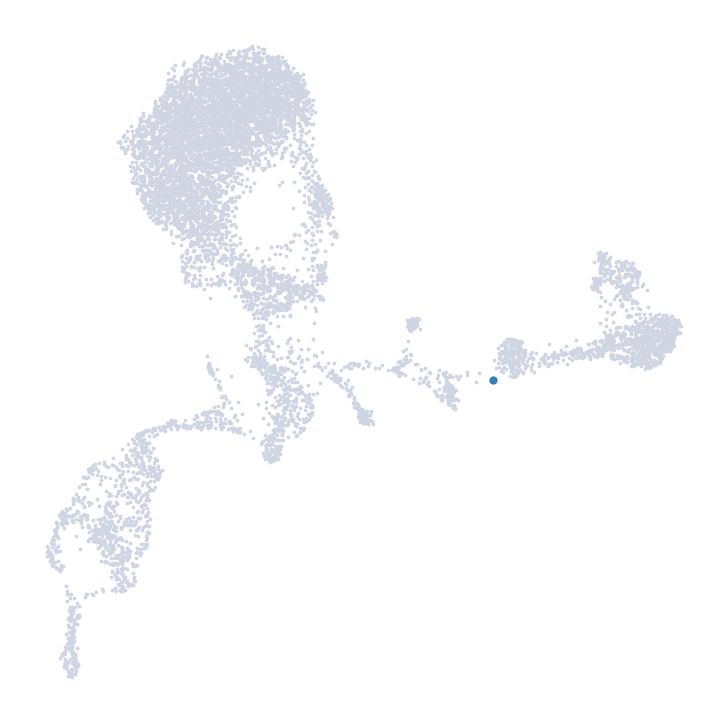

In [11]:
selection = [cells[-1]]
palantir.plot.highlight_cells_on_umap(ad, selection)
ad.obs.loc[selection, "celltype"] = "proB"
plt.show()

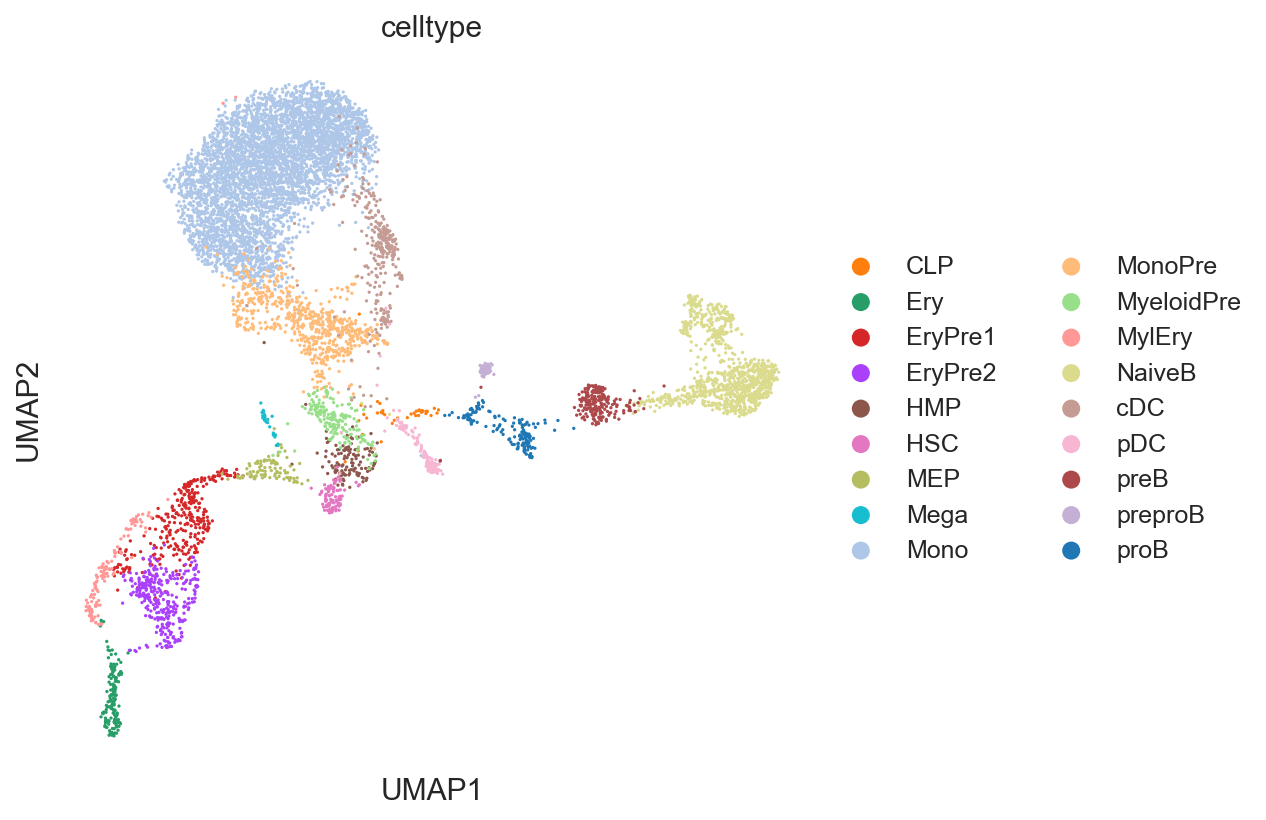

In [12]:
ad.obs["celltype"] = ad.obs["celltype"].astype(str).astype("category")
ad.uns["celltype_colors"] = [old_colors[ct] for ct in ad.obs["celltype"].cat.categories]
sc.pl.scatter(
    ad,
    basis=plbasis,
    color=[
        "celltype",
    ],
    legend_fontsize=12,
    size=10,
)

# Custom mask

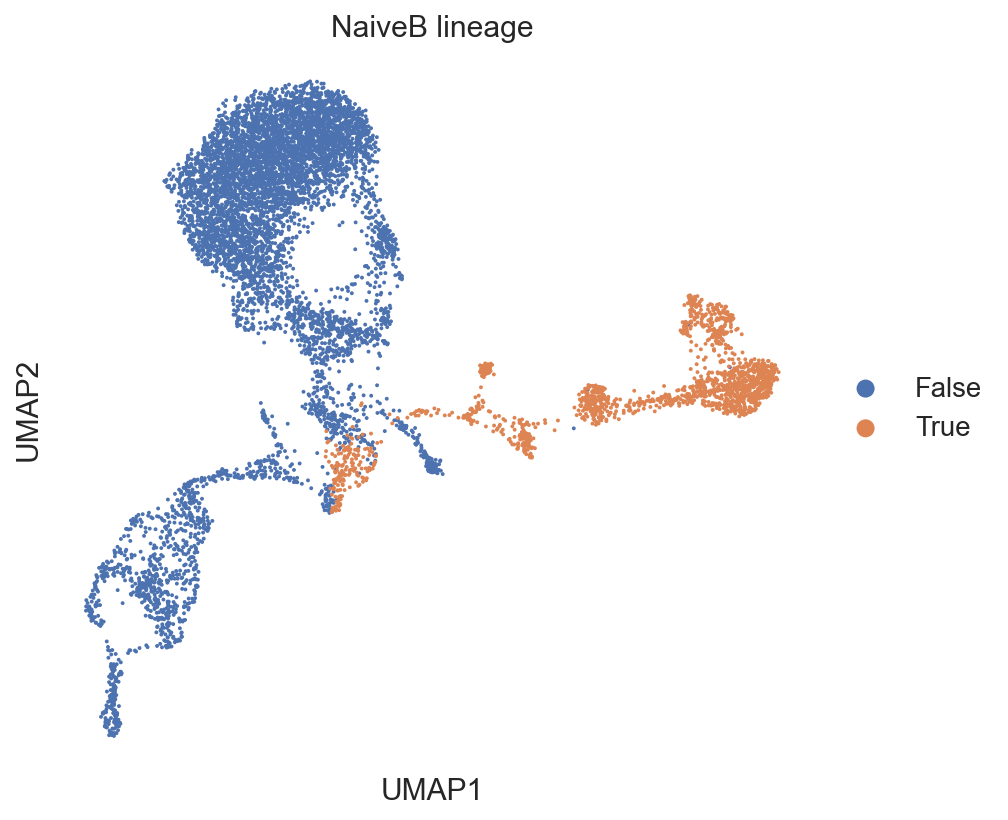

In [13]:
lineage = "Bcells"
save_as = "NaiveB"
lineage_file = "/fh/fast/setty_m/user/msetty/projects/sc-density/data/bone-marrow-tcelldep/lineage_cells.p"

with open(lineage_file, "rb") as f:
    lineage_cells = pickle.load(f)
cell_names = lineage_cells[lineage]
lineage_name = f"{save_as}_lineage"
lineage_mask = ad.obs_names.isin(cell_names) | (ad.obs["celltype"] == "preproB")
ad.obsm["custom_branch_mask"] = lineage_mask.values
ad.uns["custom_branch_mask_columns"] = [save_as]
ad.obs[lineage_name] = lineage_mask
ad.obs[lineage_name] = ad.obs[lineage_name].astype(str).astype("category")
sc.pl.scatter(ad, basis=plot_basis, color=lineage_name)

# Run Palantir

In [14]:
palantir.utils.run_diffusion_maps(ad, n_components=dm_ncomp)
ad

Determing nearest neighbor graph...


AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'hvg', 'leiden', 'neighbors', 'pca', 'sample_colors', 'umap', 'celltype_colors', 'custom_branch_mask_columns', 'NaiveB_lineage_colors', 'DM_EigenValues'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'palantir_branch_probs', 'palantir_fate_probabilities', 'custom_branch_mask'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'connectivities', 'distances', 'knn', 'DM_Similarity'

In [15]:
masks = palantir.presults.select_branch_cells(ad)

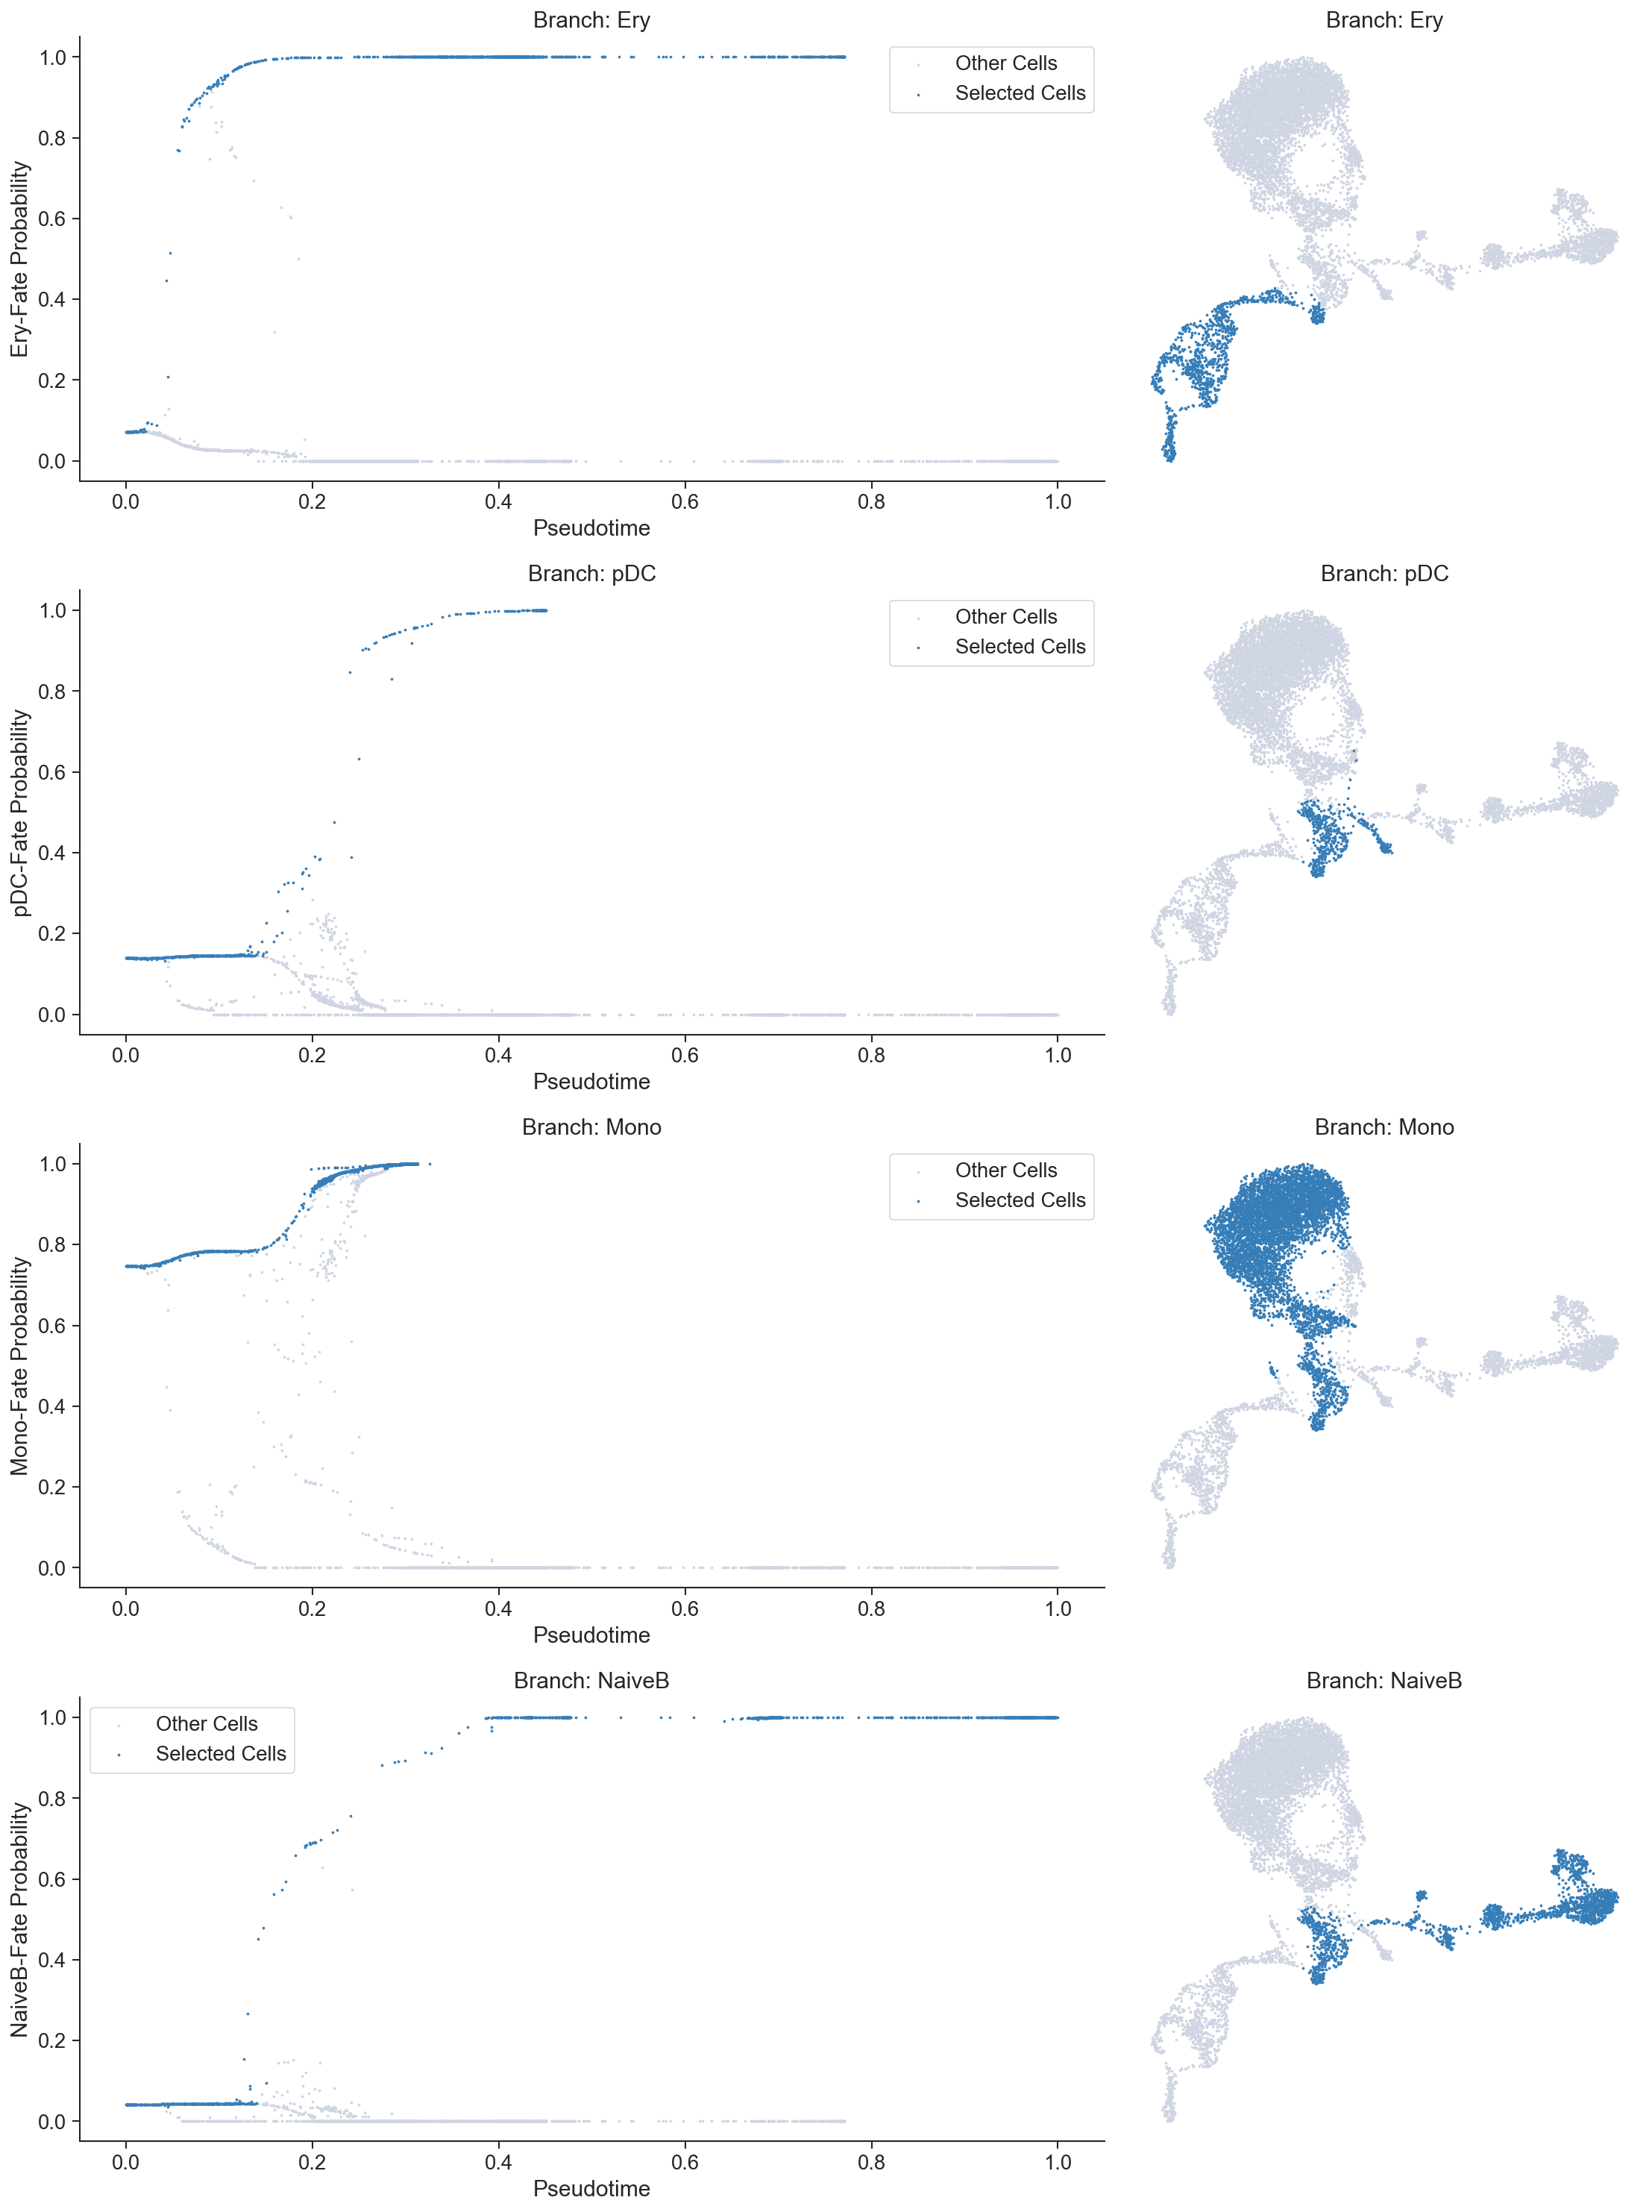

In [16]:
palantir.plot.plot_branch_selection(ad, s=1, embedding_basis=embedding_basis)
plt.show()

# Save

In [17]:
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'hvg', 'leiden', 'neighbors', 'pca', 'sample_colors', 'umap', 'celltype_colors', 'custom_branch_mask_columns', 'NaiveB_lineage_colors', 'DM_EigenValues'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'palantir_branch_probs', 'palantir_fate_probabilities', 'custom_branch_mask', 'branch_masks'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'connectivities', 'distances', 'knn', 'DM_Similarity'

In [18]:
file_path = os.path.join(out_path, "preprocessed_t-cell-depleted-bm.h5ad")
ad.write(file_path)

# Further inspection

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/palantir/plot.py:685: UserWarning: Found only 1 fates in the intersection of 4 fate-probability fates in .obsm['palantir_fate_probabilities'] fates) and 1 fate-mask fates in .obsm['custom_branch_mask'].
  warnings.warn(


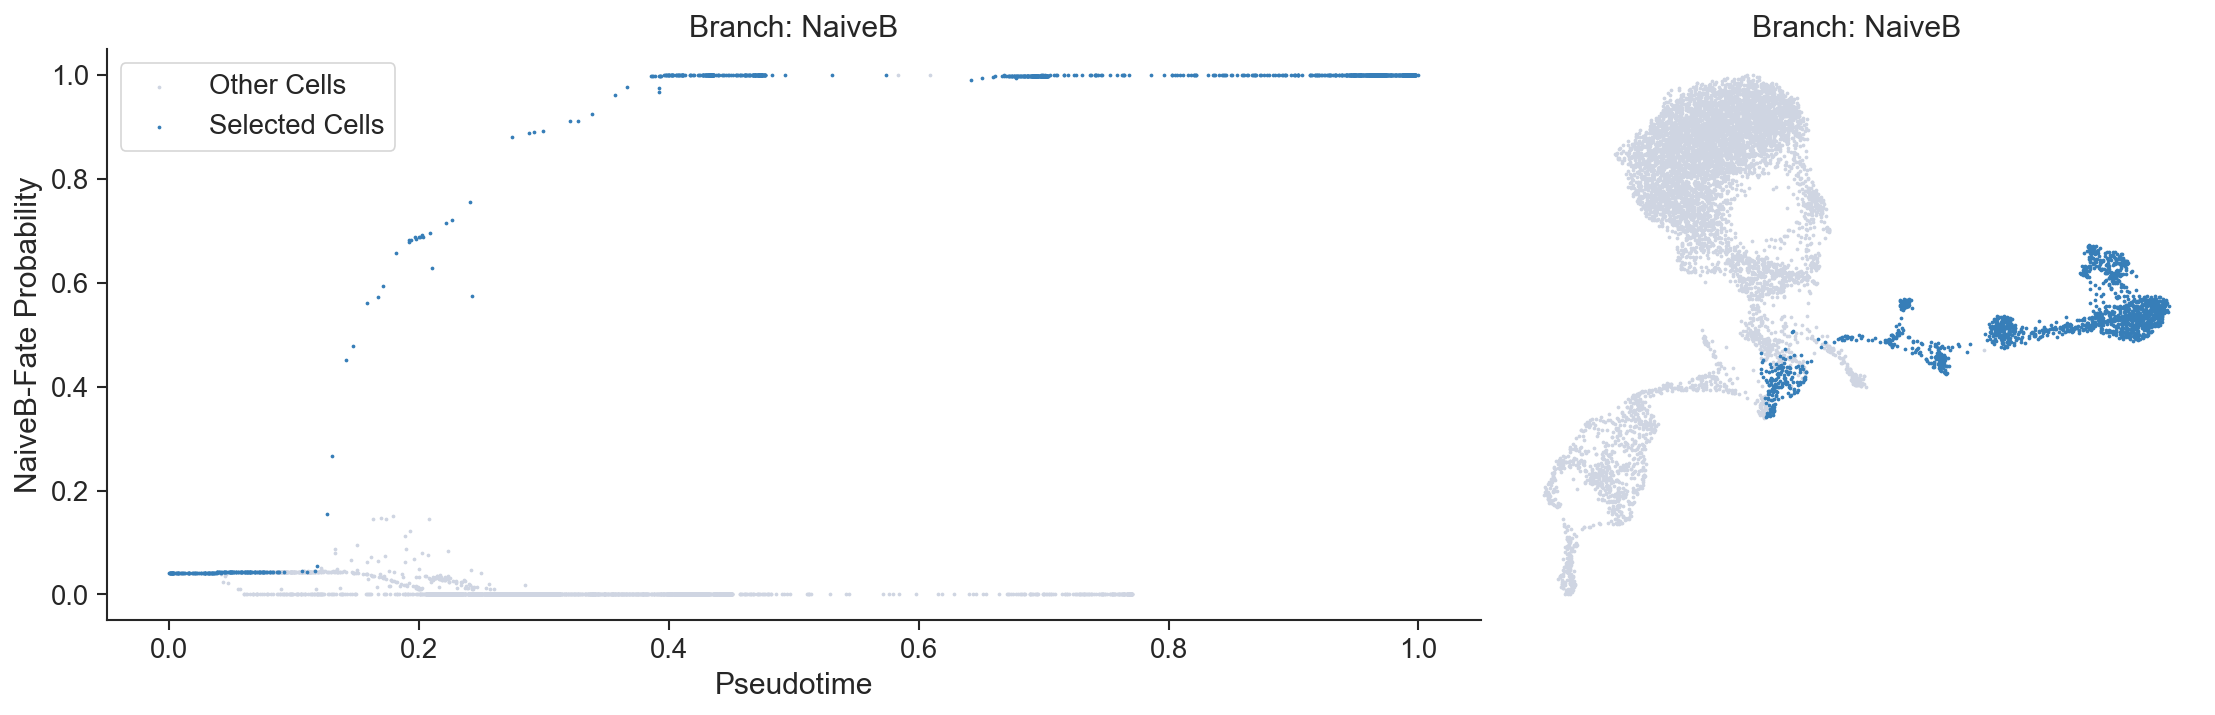

In [19]:
palantir.plot.plot_branch_selection(
    ad, masks_key="custom_branch_mask", s=1, embedding_basis=embedding_basis
)
plt.show()

In [20]:
palantir.utils.run_local_variability(ad)
palantir.utils.run_density(ad, d=1)
lvar = palantir.utils.run_low_density_variability(
    ad, cell_mask="custom_branch_mask", score_key="low_density_gene_variability_custom"
)

[2023-06-22 21:07:29,761] [INFO    ] Computing nearest neighbor distances.
[2023-06-22 21:07:30,748] [INFO    ] Using covariance function Matern52(ls=0.006271295878809611).
[2023-06-22 21:07:30,751] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2023-06-22 21:07:33,414] [INFO    ] Doing low-rank Cholesky decomposition for 8,627 samples and 5,000 landmarks.
[2023-06-22 21:07:37,997] [INFO    ] Using rank 5,000 covariance representation.
[2023-06-22 21:07:39,356] [INFO    ] Running inference using L-BFGS-B.
[2023-06-22 21:07:49,032] [INFO    ] Computing predictive function.


In [21]:
ad.var.sort_values("low_density_gene_variability_custom_NaiveB", ascending=False).head(
    20
)

,n_cells,highly_variable,means,dispersions,dispersions_norm,PeakCounts,low_density_gene_variability_custom_NaiveB
ERG,1323,True,0.577136,4.173849,13.476735,20,0.021405
AL589693.1,1751,True,0.892445,5.283953,20.723928,0,0.020319
BACH2,4069,True,2.051033,4.973633,11.578683,16,0.019452
ARPP21,806,True,0.380561,5.364349,24.324177,14,0.018962
EBF1,2504,True,1.379824,5.207299,16.200926,29,0.018726
NEGR1,3921,True,2.142374,3.733704,6.294697,4,0.018589
DIAPH3,1812,True,0.854079,4.319532,12.682438,3,0.018071
DNTT,640,True,0.221530,3.911838,6.841893,11,0.017323
ROR1,737,True,0.340949,5.422717,24.965582,21,0.017277
KCNQ5,3213,True,1.492418,4.552542,9.784195,7,0.017226


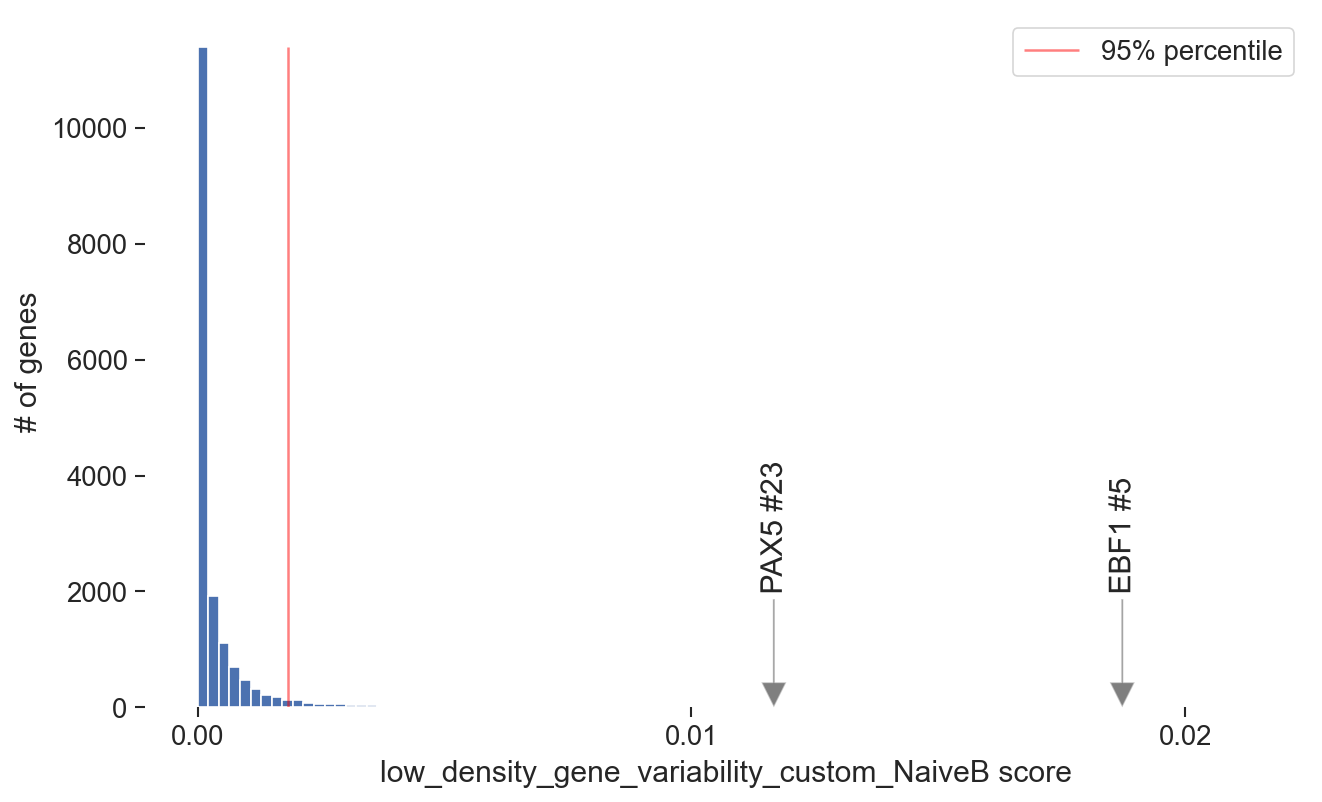

In [22]:
palantir.plot.gene_score_histogram(
    ad, "low_density_gene_variability_custom_NaiveB", ["EBF1", "PAX5"]
)
plt.show()

## New branch selection

In [23]:
palantir.utils.run_local_variability(ad)
palantir.utils.run_density(ad, d=1)
lvar = palantir.utils.run_low_density_variability(ad)

[2023-06-22 21:08:02,363] [INFO    ] Computing nearest neighbor distances.
[2023-06-22 21:08:03,096] [INFO    ] Using covariance function Matern52(ls=0.006271295878809611).
[2023-06-22 21:08:03,098] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2023-06-22 21:08:05,679] [INFO    ] Doing low-rank Cholesky decomposition for 8,627 samples and 5,000 landmarks.
[2023-06-22 21:08:09,117] [INFO    ] Using rank 5,000 covariance representation.
[2023-06-22 21:08:10,309] [INFO    ] Running inference using L-BFGS-B.
[2023-06-22 21:08:18,789] [INFO    ] Computing predictive function.


In [24]:
ad.var.sort_values("low_density_gene_variability_NaiveB", ascending=False).head(
    20
)

,n_cells,highly_variable,means,dispersions,dispersions_norm,PeakCounts,low_density_gene_variability_custom_NaiveB,low_density_gene_variability_Mono,low_density_gene_variability_pDC,low_density_gene_variability_NaiveB,low_density_gene_variability_Ery
AL589693.1,1751,True,0.892445,5.283953,20.723928,0,0.020319,0.000859,0.024786,0.022691,0.005359
ERG,1323,True,0.577136,4.173849,13.476735,20,0.021405,0.000243,0.007464,0.020000,0.001938
NEGR1,3921,True,2.142374,3.733704,6.294697,4,0.018589,0.000584,0.009868,0.018454,0.004038
DIAPH3,1812,True,0.854079,4.319532,12.682438,3,0.018071,0.000396,0.015245,0.017967,0.020476
BACH2,4069,True,2.051033,4.973633,11.578683,16,0.019452,0.000147,0.004370,0.017294,0.000837
ROR1,737,True,0.340949,5.422717,24.965582,21,0.017277,0.000004,0.000046,0.017266,0.000064
ARPP21,806,True,0.380561,5.364349,24.324177,14,0.018962,0.000011,0.002226,0.016945,0.000073
ACSM3,2498,True,1.115640,4.044171,8.938194,10,0.014378,0.000275,0.005126,0.016760,0.003262
KCNQ5,3213,True,1.492418,4.552542,9.784195,7,0.017226,0.000476,0.012548,0.016613,0.006070
DNTT,640,True,0.221530,3.911838,6.841893,11,0.017323,0.000018,0.004680,0.015127,0.000039


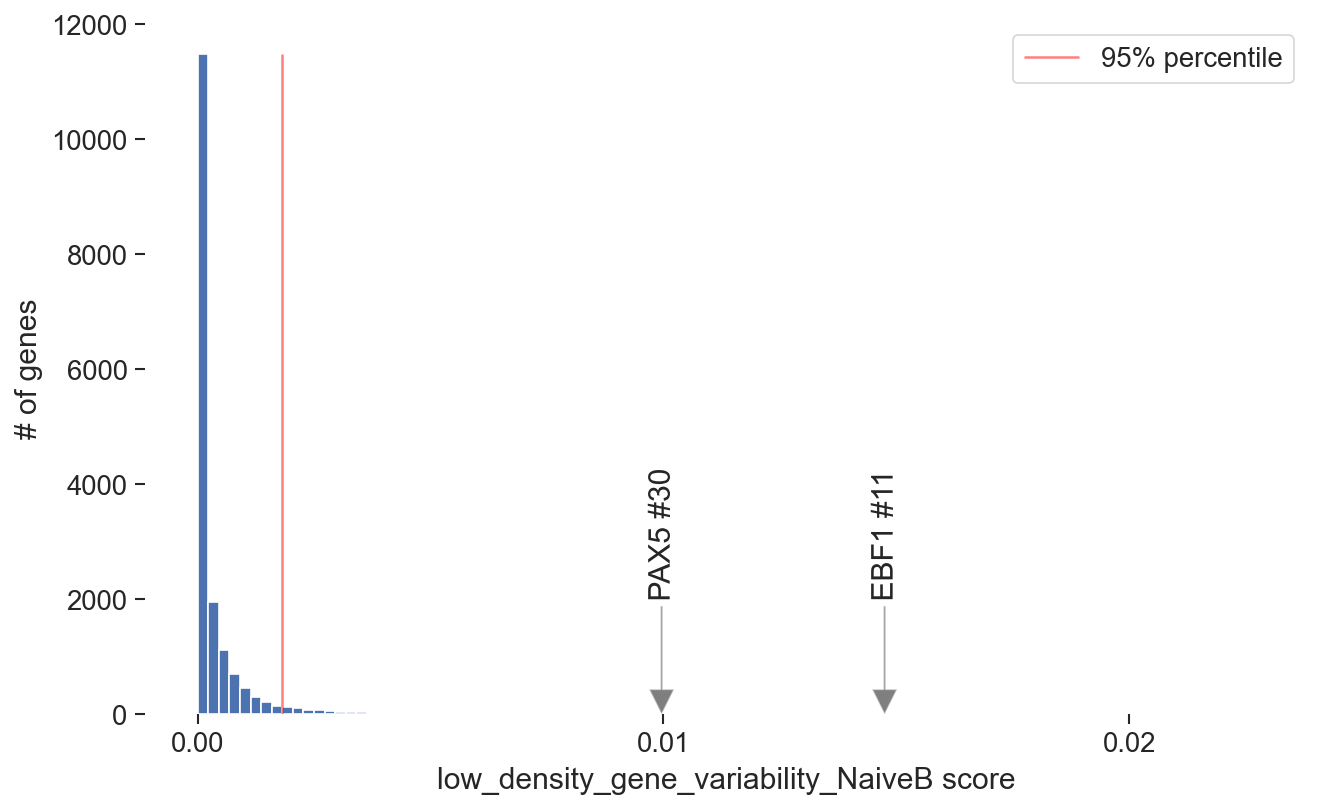

In [25]:
palantir.plot.gene_score_histogram(
    ad, "low_density_gene_variability_NaiveB", ["EBF1", "PAX5"]
)
plt.show()

In [27]:
import pwd
user_info = pwd.getpwuid(os.getuid())
author = user_info.pw_gecos
email = user_info.pw_name + "@fredhutch.org"
%load_ext watermark
%watermark -a "{author}" -e {email} -h -v -iv -m -u -w -i

Author: Dominik Otto, S2-106, x4475,umask=0007, Setty Lab,

Email: dotto@fredhutch.org

Last updated: 2023-06-22T21:14:37.840249-07:00

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.13.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 4.15.0-192-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 36
Architecture: 64bit

Hostname: gizmok125

palantir  : 1.2
matplotlib: 3.7.1
scanpy    : 1.9.3
pandas    : 1.5.3

Watermark: 2.3.1

